#Modelo de Red Neuronal para mejorar la presición de la predicción de ocupación hospitalaria

#Importación y preparación de Datos

##Datos de ocupación

In [ ]:
from datetime import datetime, timedelta
import requests
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/ocupación fundación.csv',sep= ';')


In [ ]:
print(df.head(3))
print(df.shape)

             Grupo ocupación              Fecha corte  DISPONIBLE  OCUPADA
0  OCUPACIÓN HOSPITALIZACIÓN  16/06/2020 3:02:03 a.m.          87      162
1  OCUPACIÓN HOSPITALIZACIÓN  16/06/2020 6:01:26 a.m.          83      166
2  OCUPACIÓN HOSPITALIZACIÓN  17/06/2020 3:02:40 a.m.          72      176
(5138, 4)


Creación de campos

In [ ]:
df['CAMAS TOTALES'] = df['DISPONIBLE'] + df['OCUPADA']
df['% OCUPACION'] = (df['OCUPADA'] / df['CAMAS TOTALES'])

Arreglo del campo fecha

In [ ]:
#extraer solo la fecha
df['Fecha corte'] = df['Fecha corte'].str.split().str[0]

In [ ]:
#convertir a datetime la fecha corte
df['Fecha corte'] = pd.to_datetime(df['Fecha corte'], format='%d/%m/%Y', errors='coerce')


Filtro Grupo Ocupación

In [ ]:
df['Grupo ocupación'].value_counts()

,count
Grupo ocupación,
OCUPACIÓN HOSPITALIZACIÓN,2569
OCUPACIÓN UCI,2569


In [ ]:
#filtro ocupación hospitalización ya que solo nos enfocamos en hospitalización
df = df[df['Grupo ocupación'] != 'OCUPACIÓN UCI']
df = df.drop('Grupo ocupación', axis=1)

Eliminar fechas duplicadas

In [ ]:
df = df.sort_values('% OCUPACION').drop_duplicates(subset=['Fecha corte'], keep='last')

In [ ]:
#convertir fecha en index
df = df.set_index('Fecha corte')

In [ ]:
df = df.sort_values('Fecha corte')

In [ ]:
df.shape

(1573, 4)

Rango de fechas de el dataframe

In [ ]:
print(df.index.min(), df.index.max())

2020-06-16 00:00:00 2024-12-01 00:00:00


Validación de fechas vacias

In [ ]:
fecha_inicio = df.index.min()
fecha_fin = df.index.max()
rango_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin)

# crear dataset con rango de fechas
date_df = pd.DataFrame({'Fecha corte': rango_fechas})
date_df = date_df.set_index('Fecha corte')
# Unir
df = date_df.merge(df, how='left', left_index=True, right_index=True)

In [ ]:
df.isnull().sum()

,0
DISPONIBLE,57
OCUPADA,57
CAMAS TOTALES,57
% OCUPACION,57


##Predicciones de la fundación

In [ ]:
df_pred = pd.read_csv('/content/predicciones ocupacion.csv',sep= ';')

In [ ]:
df_pred = df_pred[df_pred['Grupo ocupación'] == 'OCUPACIÓN HOSPITALIZACIÓN']
df_pred = df_pred.drop('Grupo ocupación', axis=1)
df_pred = df_pred.drop('Estado final cama', axis=1)

In [ ]:
meses = {
    'enero': '01', 'febrero': '02', 'marzo': '03',
    'abril': '04', 'mayo': '05', 'junio': '06',
    'julio': '07', 'agosto': '08', 'septiembre': '09',
    'octubre': '10', 'noviembre': '11', 'diciembre': '12'
}

In [ ]:
# Función para convertir texto de fecha
def convertir_fecha(texto):
    for mes, num in meses.items():
        if mes in texto:
            texto = texto.replace(f" de {mes} de ", f"-{num}-")
            break
    return datetime.strptime(texto, '%d-%m-%Y').date()

In [ ]:
df_pred['Día de Fecha corte'] = df_pred['Día de Fecha corte'].apply(convertir_fecha)

In [ ]:
df_pred['Día de Fecha corte'] = pd.to_datetime(
    df_pred['Día de Fecha corte'],
    format='%d de %B de %Y',
    errors='coerce'
)

In [ ]:
df_pred = df_pred.set_index('Día de Fecha corte')

In [ ]:
# Create a date range
fecha_inicio_pred = df_pred.index.min()
fecha_fin_pred = df_pred.index.max()
rango_fechas_pred = pd.date_range(start=fecha_inicio_pred, end=fecha_fin_pred)

# Create a DataFrame from the date range
date_df_pred = pd.DataFrame({'Día de Fecha corte	': rango_fechas_pred})
date_df_pred = date_df_pred.set_index('Día de Fecha corte	')
# Merge the date range DataFrame with the original DataFrame
df_pred = date_df_pred.merge(df_pred, how='left', left_index=True, right_index=True)

In [ ]:
#Camas disponibles desde la tabla de Datos de ocupación
df_pred['CAMAS DISPONIBLES'] = df['CAMAS TOTALES']

In [ ]:
df_pred.isnull().sum()

,0
Recuento definido de Cama,0
CAMAS DISPONIBLES,5


In [ ]:
for column in ['CAMAS DISPONIBLES']:
    median_value = df_pred[column].median()
    df_pred[column].fillna(median_value, inplace=True)

<ipython-input-107-b7ba27f870f6>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pred[column].fillna(median_value, inplace=True)


In [ ]:
df_pred['% OCUPACION'] = (df_pred['Recuento definido de Cama'] / df_pred['CAMAS DISPONIBLES'])

In [ ]:
df_pred.isnull().sum()

,0
Recuento definido de Cama,0
CAMAS DISPONIBLES,0
% OCUPACION,0


In [ ]:
df_pred.head(3)

,Recuento definido de Cama,CAMAS DISPONIBLES,% OCUPACION
Día de Fecha corte,,,
2024-01-01,227,239.0,0.949791
2024-01-02,234,241.0,0.970954
2024-01-03,236,245.0,0.963265


In [ ]:
df['OCUPADA'] = pd.to_numeric(df['OCUPADA'], errors='coerce')

#Analisis Exploratorio

In [ ]:
df.dtypes

,0
DISPONIBLE,float64
OCUPADA,float64
CAMAS TOTALES,float64
% OCUPACION,float64


In [ ]:
print(fecha_inicio)
print(fecha_fin_pred)

2020-06-16 00:00:00
2024-05-29 00:00:00


##Grafica de comportamiento Variables a Trabajar

<Figure size 1500x500 with 0 Axes>

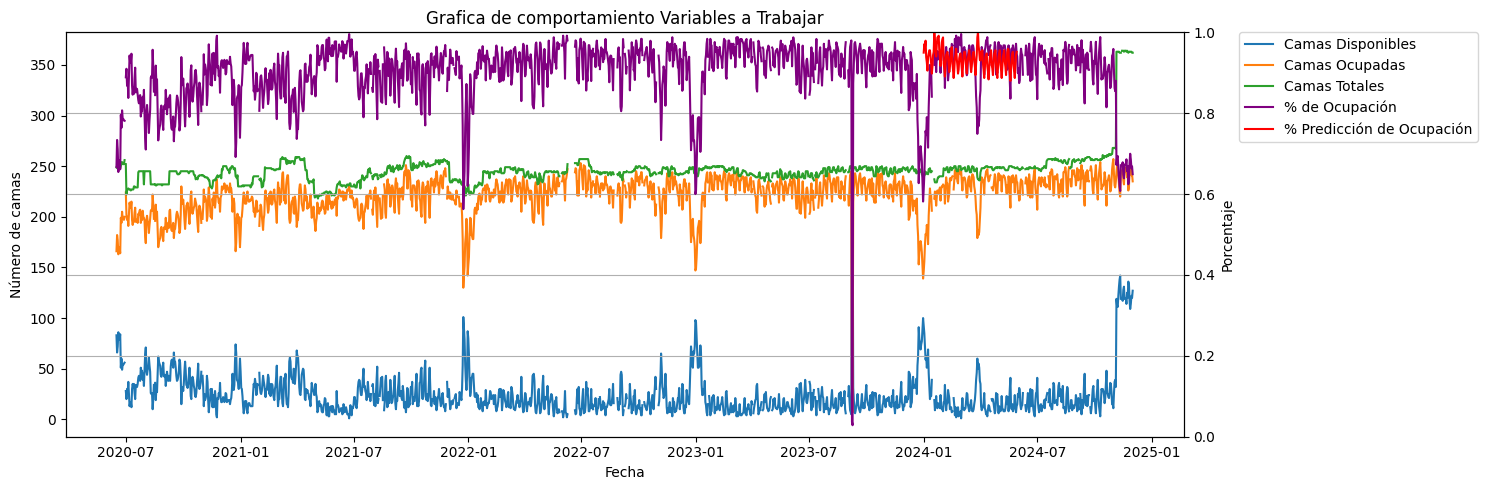

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Primer eje y (Camas Disponibles, Ocupadas y Totales)
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(df.index, df['DISPONIBLE'], label='Camas Disponibles')
ax1.plot(df.index, df['OCUPADA'], label='Camas Ocupadas')
ax1.plot(df.index, df['CAMAS TOTALES'], label='Camas Totales')
ax1.set_ylabel('Número de camas')

# Segundo eje y (Porcentajes)
ax2 = ax1.twinx()
ax2.set_ylim(0, None)
ax2.plot(df.index, df['% OCUPACION'], color='purple', label='% de Ocupación')
ax2.plot(df_pred.index,df_pred['% OCUPACION'],color ='red', label = '% Predicción de Ocupación')
ax2.set_ylabel('Porcentaje')

# Configuración de la leyenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

# Configuración adicional
ax1.set_xlabel('Fecha')
plt.title('Grafica de comportamiento Variables a Trabajar')
plt.grid()
plt.tight_layout()  # Ajusta automáticamente los márgenes
plt.show()


In [ ]:
df

,DISPONIBLE,OCUPADA,CAMAS TOTALES,% OCUPACION
Fecha corte,,,,
2020-06-16,83.0,166.0,249.0,0.666667
2020-06-17,66.0,182.0,248.0,0.733871
2020-06-18,72.0,177.0,249.0,0.710843
2020-06-19,86.0,163.0,249.0,0.654618
2020-06-20,82.0,167.0,249.0,0.670683
...,...,...,...,...
2024-11-27,109.0,254.0,363.0,0.699725
2024-11-28,114.0,249.0,363.0,0.685950
2024-11-29,122.0,241.0,363.0,0.663912


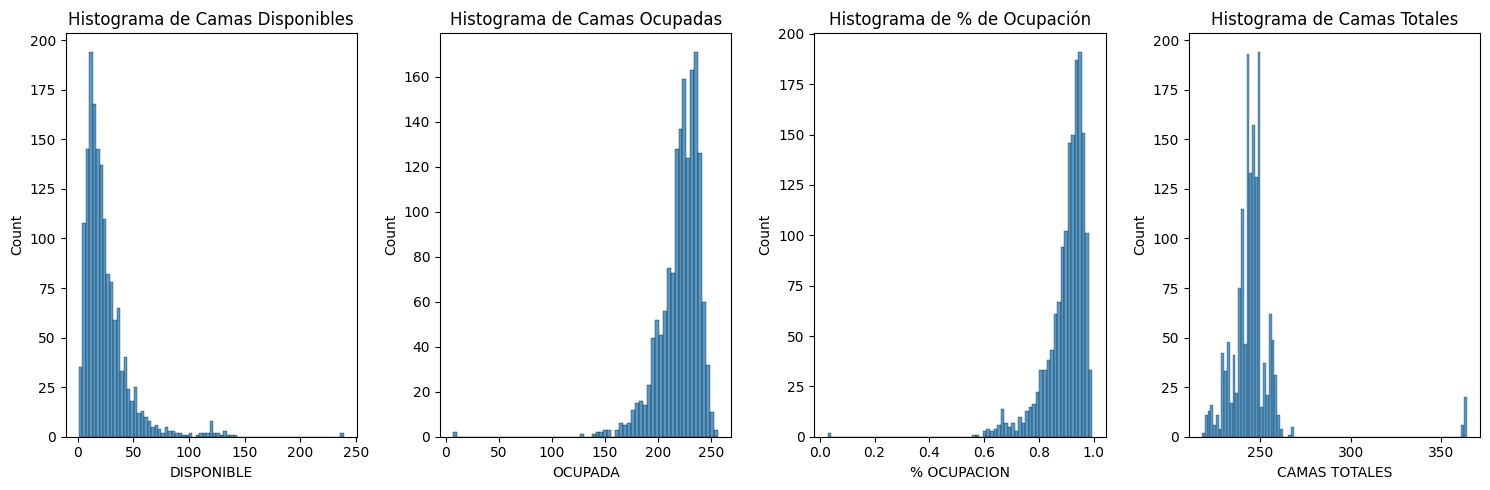

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

sns.histplot(df['DISPONIBLE'], ax=axes[0])
axes[0].set_title('Histograma de Camas Disponibles')

sns.histplot(df['OCUPADA'], ax=axes[1])
axes[1].set_title('Histograma de Camas Ocupadas')

sns.histplot(df['% OCUPACION'], ax=axes[2])
axes[2].set_title('Histograma de % de Ocupación')

sns.histplot(df['CAMAS TOTALES'], ax=axes[3])
axes[3].set_title('Histograma de Camas Totales')

plt.tight_layout()
plt.show()

<Axes: >

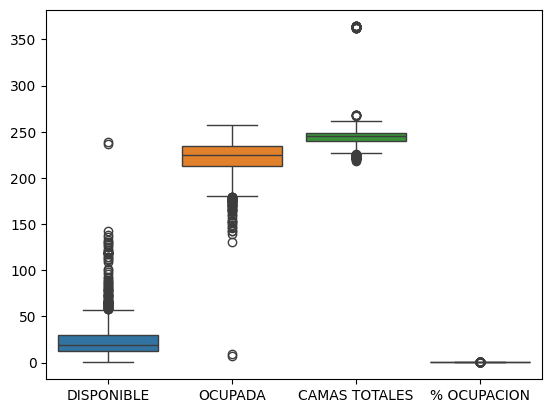

In [ ]:
sns.boxplot(data=df[['DISPONIBLE', 'OCUPADA', 'CAMAS TOTALES', '% OCUPACION']])

<Axes: >

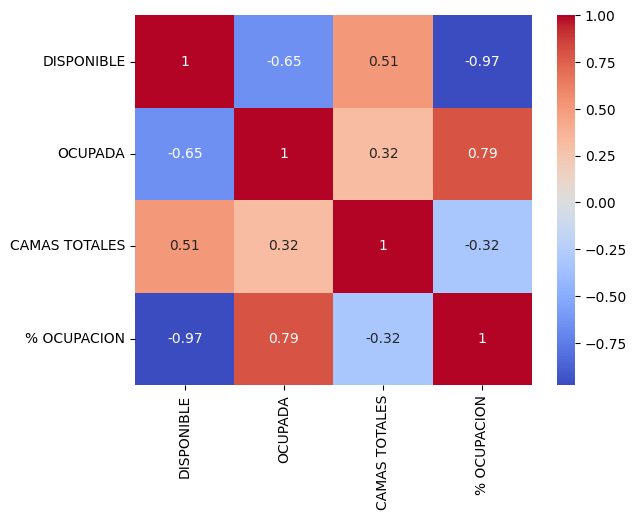

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

#Preprocesamiento

In [ ]:
#filtro de datos luego de 2024-11
df_preprocessed = df[df.index < datetime(2024, 5, 29)]

##Inputar faltantes

In [ ]:
#borrar outliers
df_preprocessed.loc[df_preprocessed['OCUPADA'] < 15, ['OCUPADA','DISPONIBLE','CAMAS TOTALES','% OCUPACION']] = np.nan

In [ ]:
# Imputar valores faltantes por la mediana
for column in ['OCUPADA', 'DISPONIBLE', 'CAMAS TOTALES', '% OCUPACION']:
    median_value = df_preprocessed[column].median()
    df_preprocessed[column].fillna(median_value, inplace=True)

<ipython-input-44-bab0fbff59de>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_preprocessed[column].fillna(median_value, inplace=True)
<ipython-input-44-bab0fbff59de>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed[column].fillna(median_value, inplace=True)


In [ ]:
df_preprocessed.isnull().sum()

,0
DISPONIBLE,0
OCUPADA,0
CAMAS TOTALES,0
% OCUPACION,0


<Figure size 1500x500 with 0 Axes>

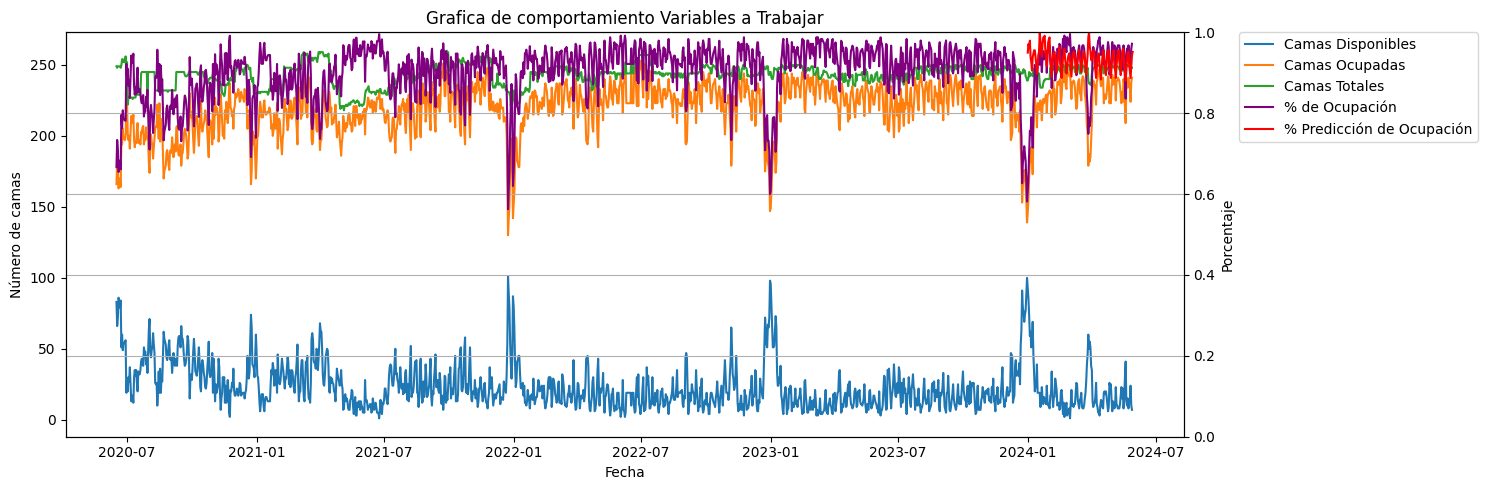

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Primer eje y (Camas Disponibles, Ocupadas y Totales)
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(df_preprocessed.index, df_preprocessed['DISPONIBLE'], label='Camas Disponibles')
ax1.plot(df_preprocessed.index, df_preprocessed['OCUPADA'], label='Camas Ocupadas')
ax1.plot(df_preprocessed.index, df_preprocessed['CAMAS TOTALES'], label='Camas Totales')
ax1.set_ylabel('Número de camas')

# Segundo eje y (Porcentajes)
ax2 = ax1.twinx()
ax2.set_ylim(0, None)
ax2.plot(df_preprocessed.index, df_preprocessed['% OCUPACION'], color='purple', label='% de Ocupación')
ax2.plot(df_pred.index,df_pred['% OCUPACION'],color ='red', label = '% Predicción de Ocupación')
ax2.set_ylabel('Porcentaje')

# Configuración de la leyenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

# Configuración adicional
ax1.set_xlabel('Fecha')
plt.title('Grafica de comportamiento Variables a Trabajar')
plt.grid()
plt.tight_layout()
plt.show()


##Estandarización

<Axes: >

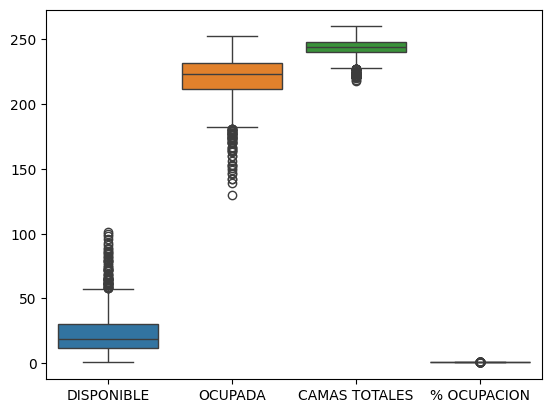

In [ ]:
sns.boxplot(df_preprocessed)

Variable a predecir

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [ ]:
minmaxscaler = MinMaxScaler(feature_range=(-1,1))
df_preprocessed['% OCUPACION'] = minmaxscaler.fit_transform(df_preprocessed[['% OCUPACION']])

<ipython-input-49-db6cd59e8e32>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['% OCUPACION'] = minmaxscaler.fit_transform(df_preprocessed[['% OCUPACION']])


componentes predictores

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the selected columns and transform them
for column in ['DISPONIBLE', 'OCUPADA', 'CAMAS TOTALES']:
    df_preprocessed[column] = scaler.fit_transform(df_preprocessed[[column]])

<ipython-input-50-9a94219489df>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed[column] = scaler.fit_transform(df_preprocessed[[column]])
<ipython-input-50-9a94219489df>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed[column] = scaler.fit_transform(df_preprocessed[[column]])
<ipython-input-50-9a94219489df>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

<Axes: >

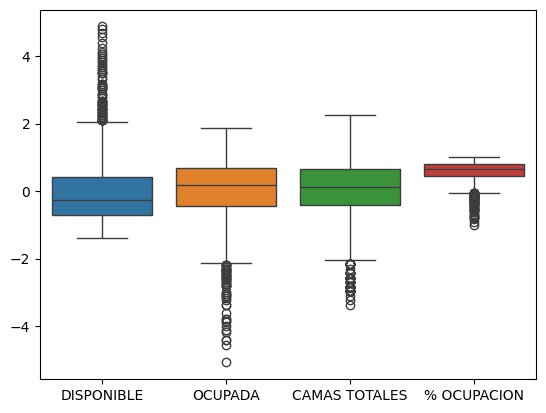

In [ ]:
sns.boxplot(df_preprocessed)

##Separación de grupos

In [ ]:
Df_Train = df_preprocessed.loc["2020-06-16":"2023-06-16"]
DF_Validation = df_preprocessed.loc["2023-06-17":"2023-12-31"]
DF_Test = df_preprocessed.loc["2024-01-01":]

<Figure size 1500x500 with 0 Axes>

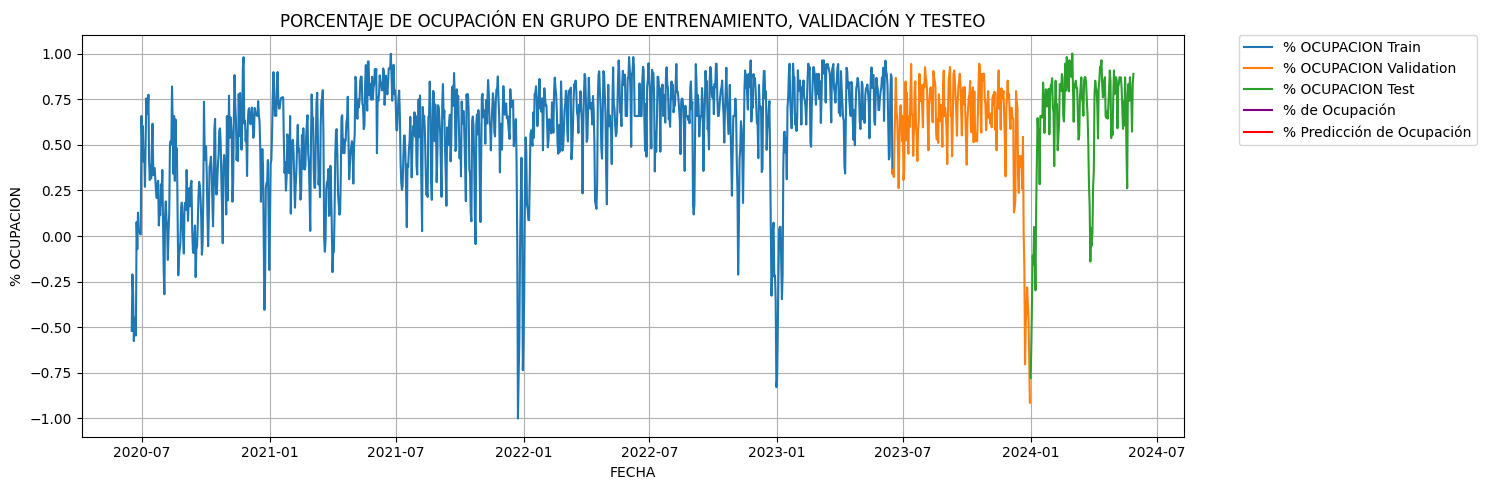

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Primer eje y (Camas Disponibles, Ocupadas y Totales)
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(Df_Train.index, Df_Train['% OCUPACION'], label='% OCUPACION Train')
ax1.plot(DF_Validation.index, DF_Validation['% OCUPACION'], label='% OCUPACION Validation')
ax1.plot(DF_Test.index, DF_Test['% OCUPACION'], label='% OCUPACION Test')
ax1.set_ylabel('% OCUPACION')



# Configuración de la leyenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

# Configuración adicional
ax1.set_xlabel('FECHA')
plt.title('PORCENTAJE DE OCUPACIÓN EN GRUPO DE ENTRENAMIENTO, VALIDACIÓN Y TESTEO')
plt.grid()
plt.tight_layout()  # Ajusta automáticamente los márgenes
plt.show()

convertir a arreglo numpy

In [ ]:
Df_Train.values

array([[ 3.74958182, -3.04520786,  0.78083345, -0.5202925 ],
       [ 2.68288819, -2.14042761,  0.64700014, -0.20999784],
       [ 3.0593683 , -2.42317144,  0.78083345, -0.31632049],
       ...,
       [-1.01916617,  1.02630328,  0.2455002 ,  0.88684948],
       [-0.95641948,  0.91320574,  0.11166688,  0.86738594],
       [ 0.73774099, -0.89635476, -0.55749969,  0.3426123 ]])

In [ ]:
Df_Train

,DISPONIBLE,OCUPADA,CAMAS TOTALES,% OCUPACION
Fecha corte,,,,
2020-06-16,3.749582,-3.045208,0.780833,-0.520293
2020-06-17,2.682888,-2.140428,0.647000,-0.209998
2020-06-18,3.059368,-2.423171,0.780833,-0.316320
2020-06-19,3.937822,-3.214854,0.780833,-0.575921
2020-06-20,3.686835,-2.988659,0.780833,-0.501750
...,...,...,...,...
2023-06-12,0.424008,-0.670160,-0.691333,0.436771
2023-06-13,-0.642686,0.517364,-0.156000,0.770738
2023-06-14,-1.019166,1.026303,0.245500,0.886849


##Arreglos lookback

In [ ]:

lookback = 30
def create_sequences_multivariate(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length), :3]  # Selecciona todas las features
        y = data[i+seq_length, 3]      # Asume que la columna 3 es la variable objetivo
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Uso de la nueva función
X_train, y_train = create_sequences_multivariate(Df_Train.values, lookback)
X_val, y_val = create_sequences_multivariate(DF_Validation.values, lookback)
X_test, y_test = create_sequences_multivariate(DF_Test.values, lookback)


#Creación de modelo

In [ ]:
#resultados de gridsearch {'units': 128, 'dropout_rate': 0.3, 'dense_units': 32, 'epochs': 20, 'batch_size': 32}

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Definir el modelo
model = Sequential()
model.add(LSTM(128, input_shape=(30, 3), return_sequences=False))  # Una capa LSTM
# # Segunda capa LSTM
model.add(Dropout(0.3))  # Dropout adicional
model.add(Dense(32, activation='linear'))  # Otra capa más pequeña para refinar la secuencia
model.add(Dense(1, activation='linear'))  # Predicción de una sola salida (por ejemplo, % OCUPACION)

# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

# Entrenamiento
modellstm = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.2031 - mse: 0.2031 - val_loss: 0.0458 - val_mse: 0.0458
Epoch 2/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 3/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0508 - mse: 0.0508 - val_loss: 0.0297 - val_mse: 0.0297
Epoch 4/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0426 - mse: 0.0426 - val_loss: 0.0327 - val_mse: 0.0327
Epoch 5/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0384 - mse: 0.0384 - val_loss: 0.0295 - val_mse: 0.0295
Epoch 6/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0329 - mse: 0.0329 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 7/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0267 - val_mse: 0.0267
Epoch 8/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 9/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0313 - mse: 0.

#Evaluación del modelo

In [ ]:
# Evaluar el modelo
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Resultado de entrenamiento: %.5f MSE' % (trainScore[0]))
validationScore = model.evaluate(X_val, y_val, verbose=0)
print('Resultado de validación: %.5f MSE' % (validationScore[0]))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Resultado de prueba: %.5f MSE' % (testScore[0]))

Resultado de entrenamiento: 0.02238 MSE
Resultado de validación: 0.02107 MSE
Resultado de prueba: 0.02199 MSE


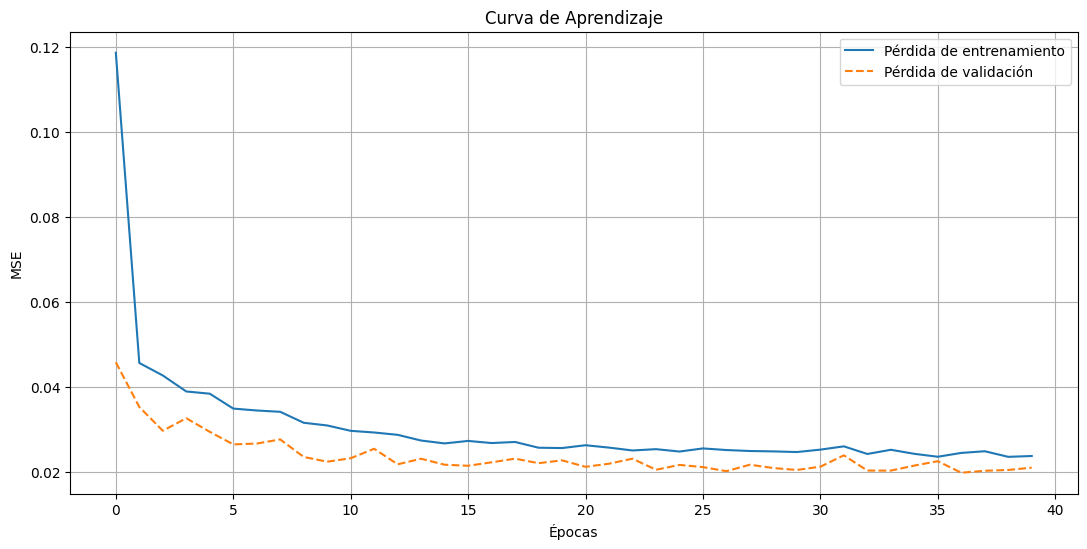

In [ ]:
plt.figure(figsize=(13,6))
plt.plot(modellstm.history['loss'], label='Pérdida de entrenamiento')
plt.plot(modellstm.history['val_loss'], label='Pérdida de validación', linestyle='--')
plt.title("Curva de Aprendizaje")
plt.ylabel('MSE')
plt.xlabel('Épocas')
plt.legend()
plt.grid()
plt.show()


In [ ]:
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [ ]:
X_test.shape

(118, 30, 3)

In [ ]:
test_predictions.shape

(118, 1)

In [ ]:
DF_Test.index.to_numpy().shape

(149,)

In [ ]:
fechas_train = Df_Train.index.to_numpy()
fechas_validacion = DF_Validation.index.to_numpy()
fechas_test = DF_Test.index.to_numpy()

In [ ]:
train_predictions = train_predictions.reshape(-1)
fechas_train = fechas_train[:len(train_predictions)]

val_predictions = val_predictions.reshape(-1)
fechas_validacion = fechas_validacion[:len(val_predictions)]

test_predictions = test_predictions.reshape(-1)
fechas_test = fechas_test[:len(test_predictions)]

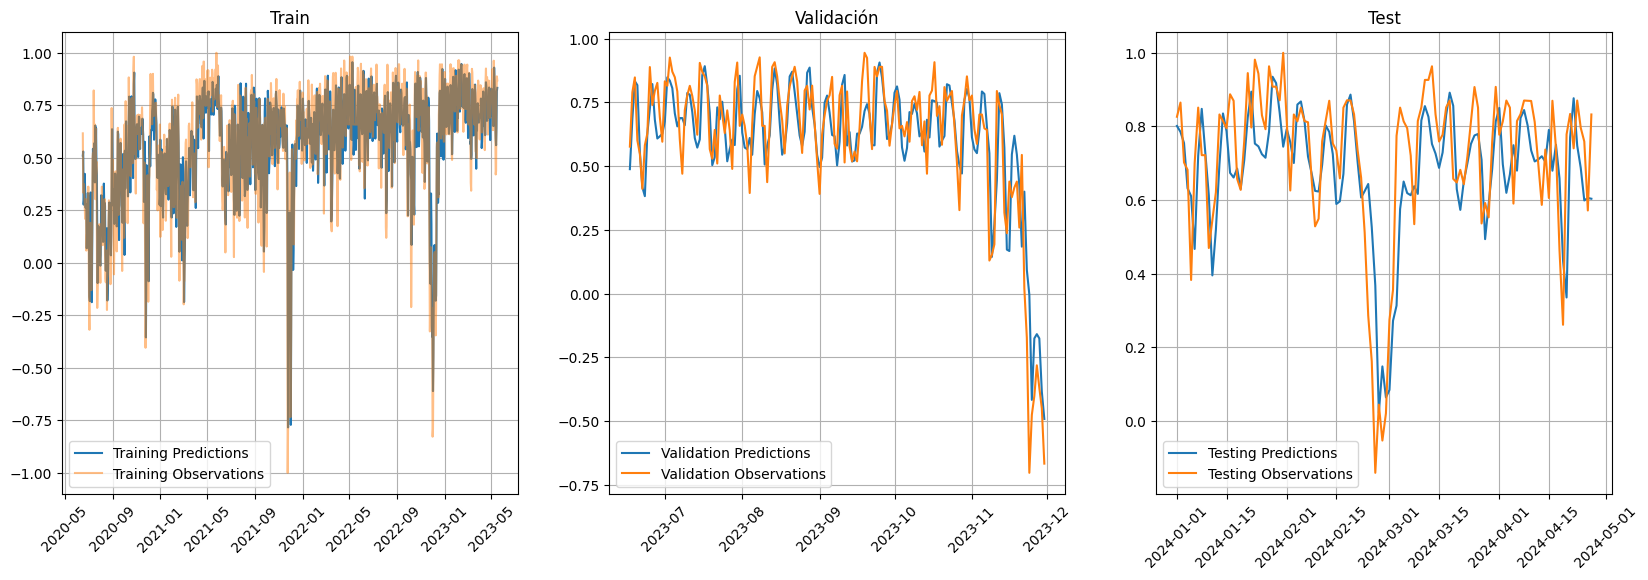

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Gráfico 1: Predicciones de entrenamiento vs. Observaciones de entrenamiento
axes[0].plot(fechas_train, train_predictions, label='Training Predictions')
axes[0].plot(fechas_train, y_train, label='Training Observations',alpha=0.5)
axes[0].set_title('Train')
axes[0].legend()
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Predicciones de validación vs. Observaciones de validación
axes[1].plot(fechas_validacion, val_predictions, label='Validation Predictions')
axes[1].plot(fechas_validacion, y_val, label='Validation Observations')
axes[1].set_title('Validación')
axes[1].legend()
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)


# Gráfico 3: Predicciones de prueba vs. Observaciones de prueba
axes[2].plot(fechas_test, test_predictions, label='Testing Predictions')
axes[2].plot(fechas_test, y_test, label='Testing Observations')
axes[2].set_title('Test')
axes[2].legend()
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=45)


#plt.tight_layout()
plt.show()

#Comparación con predicción actual

In [ ]:
# Desescalar datos

test_predictions_original_scale = minmaxscaler.inverse_transform(test_predictions.reshape(-1, 1))
y_test_original_scale = minmaxscaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
df_pred_recortado = df_pred[df_pred.index <= '2024-04-27']

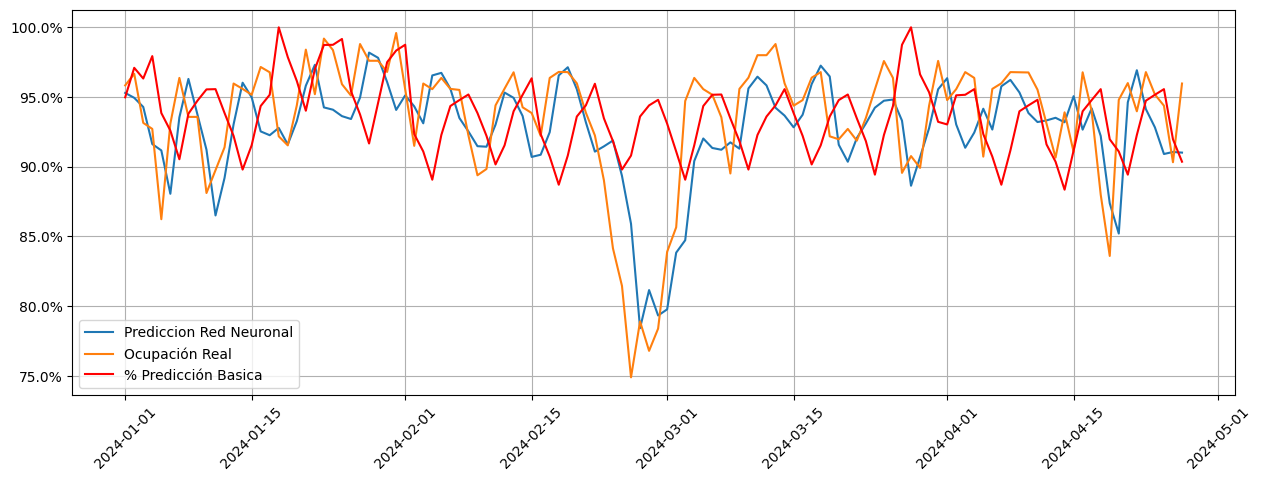

In [ ]:
from matplotlib.ticker import PercentFormatter
plt.figure(figsize=(15, 5))
plt.plot(fechas_test, test_predictions_original_scale, label='Prediccion Red Neuronal')
plt.plot(fechas_test, y_test_original_scale, label='Ocupación Real')
plt.plot(df_pred_recortado.index,df_pred_recortado['% OCUPACION'],color ='red', label = '% Predicción Basica')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))  # Cambia xmax=1 si los datos ya están en decimales
plt.legend()
plt.grid(True)
plt.tick_params(axis='x', rotation=45)

In [ ]:
y_test_original_scale

array([[0.95833333],
       [0.96666667],
       [0.93145161],
       [0.92712551],
       [0.86234818],
       [0.93089431],
       [0.96370968],
       [0.93574297],
       [0.93574297],
       [0.88114754],
       [0.89754098],
       [0.91393443],
       [0.95967742],
       [0.95582329],
       [0.9516129 ],
       [0.97154472],
       [0.96774194],
       [0.9218107 ],
       [0.91532258],
       [0.944     ],
       [0.984     ],
       [0.952     ],
       [0.99190283],
       [0.98367347],
       [0.95918367],
       [0.95102041],
       [0.988     ],
       [0.976     ],
       [0.976     ],
       [0.968     ],
       [0.99593496],
       [0.95546559],
       [0.91497976],
       [0.95967742],
       [0.95564516],
       [0.96370968],
       [0.95582329],
       [0.95510204],
       [0.92244898],
       [0.89387755],
       [0.89837398],
       [0.944     ],
       [0.956     ],
       [0.96774194],
       [0.94262295],
       [0.93852459],
       [0.92213115],
       [0.963

In [ ]:
test_predictions_original_scale

array([[0.95293164],
       [0.94942445],
       [0.9428621 ],
       [0.9162466 ],
       [0.91169786],
       [0.8806038 ],
       [0.9354191 ],
       [0.96297777],
       [0.9374284 ],
       [0.91216767],
       [0.86504793],
       [0.89199114],
       [0.9303833 ],
       [0.9602628 ],
       [0.94982594],
       [0.925336  ],
       [0.92260146],
       [0.9278475 ],
       [0.9159727 ],
       [0.9327168 ],
       [0.9581503 ],
       [0.97309536],
       [0.9425475 ],
       [0.9409038 ],
       [0.93628657],
       [0.9342271 ],
       [0.9495596 ],
       [0.9818545 ],
       [0.97811514],
       [0.9607364 ],
       [0.9407436 ],
       [0.9511718 ],
       [0.9432988 ],
       [0.9311394 ],
       [0.96549004],
       [0.9673285 ],
       [0.9559544 ],
       [0.9349391 ],
       [0.925307  ],
       [0.9147351 ],
       [0.91436744],
       [0.93013567],
       [0.9532077 ],
       [0.9494064 ],
       [0.93638057],
       [0.90703243],
       [0.90860605],
       [0.924

In [ ]:
pd.set_option('display.max_rows', None)
print(df_pred_recortado['% OCUPACION'])
pd.reset_option('display.max_rows')

Día de Fecha corte\t
2024-01-01    0.949791
2024-01-02    0.970954
2024-01-03    0.963265
2024-01-04    0.979339
2024-01-05    0.938525
2024-01-06    0.925926
2024-01-07    0.905350
2024-01-08    0.938017
2024-01-09    0.947368
2024-01-10    0.955466
2024-01-11    0.955645
2024-01-12    0.938525
2024-01-13    0.922131
2024-01-14    0.897959
2024-01-15    0.915323
2024-01-16    0.943548
2024-01-17    0.951613
2024-01-18    1.000000
2024-01-19    0.978632
2024-01-20    0.961538
2024-01-21    0.940171
2024-01-22    0.970085
2024-01-23    0.987342
2024-01-24    0.987448
2024-01-25    0.991632
2024-01-26    0.954167
2024-01-27    0.937500
2024-01-28    0.916667
2024-01-29    0.945833
2024-01-30    0.975000
2024-01-31    0.983333
2024-02-01    0.987500
2024-02-02    0.923387
2024-02-03    0.910931
2024-02-04    0.890688
2024-02-05    0.922764
2024-02-06    0.943548
2024-02-07    0.947791
2024-02-08    0.951807
2024-02-09    0.938525
2024-02-10    0.922131
2024-02-11    0.901639
2024-02-12   

In [ ]:
y_test.reshape(-1,1).shape

(118, 1)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_original_scale, test_predictions_original_scale)
mae = mean_absolute_error(y_test_original_scale, test_predictions_original_scale)
rmse = np.sqrt(mse)

print('Diferencia de Error entre Predicción de la Red Neuronal y la Ocupación Real')
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Diferencia de Error entre Predicción de la Red Neuronal y la Ocupación Real
Mean Squared Error (MSE): 0.001031303122940721
Mean Squared Error (RMSE): 0.03211390855907641
Mean Absolute Error (MAE): 0.024383317118097863


In [ ]:
test_predictions_original_scale

array([[0.95293164],
       [0.94942445],
       [0.9428621 ],
       [0.9162466 ],
       [0.91169786],
       [0.8806038 ],
       [0.9354191 ],
       [0.96297777],
       [0.9374284 ],
       [0.91216767],
       [0.86504793],
       [0.89199114],
       [0.9303833 ],
       [0.9602628 ],
       [0.94982594],
       [0.925336  ],
       [0.92260146],
       [0.9278475 ],
       [0.9159727 ],
       [0.9327168 ],
       [0.9581503 ],
       [0.97309536],
       [0.9425475 ],
       [0.9409038 ],
       [0.93628657],
       [0.9342271 ],
       [0.9495596 ],
       [0.9818545 ],
       [0.97811514],
       [0.9607364 ],
       [0.9407436 ],
       [0.9511718 ],
       [0.9432988 ],
       [0.9311394 ],
       [0.96549004],
       [0.9673285 ],
       [0.9559544 ],
       [0.9349391 ],
       [0.925307  ],
       [0.9147351 ],
       [0.91436744],
       [0.93013567],
       [0.9532077 ],
       [0.9494064 ],
       [0.93638057],
       [0.90703243],
       [0.90860605],
       [0.924

In [ ]:


mse = mean_squared_error(np.array(df_pred_recortado['% OCUPACION']).reshape(-1, 1), y_test_original_scale)
mae = mean_absolute_error(np.array(df_pred_recortado['% OCUPACION']).reshape(-1, 1), y_test_original_scale)
rmse = np.sqrt(mse)
print('Diferencia de Error entre Predicción que hace actualmente el hospital y la Ocupación Real')
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Diferencia de Error entre Predicción que hace actualmente el hospital y la Ocupación Real
Mean Squared Error (MSE): 0.0026723025191292865
Mean Squared Error (RMSE): 0.05169431805459171
Mean Absolute Error (MAE): 0.039234208810387056
